id         0
boneage    0
male       0
dtype: int64
MAE: 32.87
RMSE: 40.84
R² Score: 0.06


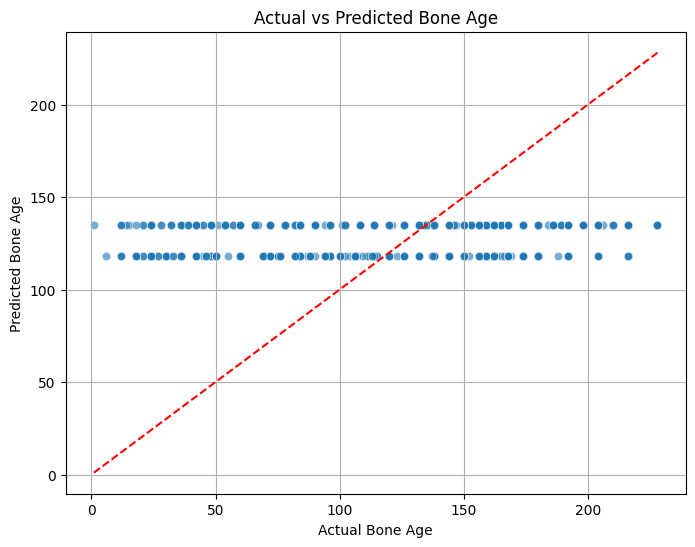

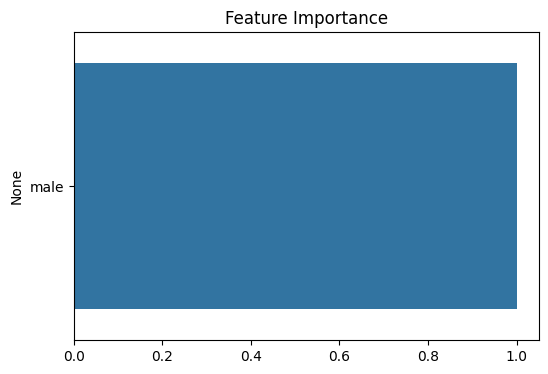

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the datasets
train_df = pd.read_csv('/content/boneage-training-dataset.csv')
test_df = pd.read_csv('/content/boneage-test-dataset.csv')

# Step 2: Basic Preprocessing
# Check for nulls
print(train_df.isnull().sum())

# Features: 'male' is already binary, use as is
X = train_df[['male']]
y = train_df['boneage']

# Step 3: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Predict and Evaluate
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 6: Plot actual vs predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Bone Age")
plt.ylabel("Predicted Bone Age")
plt.title("Actual vs Predicted Bone Age")
plt.grid(True)
plt.show()

# Step 7: Feature Importance
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.show()


In [12]:
import zipfile
import os

# Path to already uploaded ZIP file
zip_path = "/content/boneage-dataset.zip"

# Extract to target directory
extract_path = "/content/boneage_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirm extraction
print("Extracted folders:", os.listdir(extract_path))


Extracted folders: ['boneage-test-dataset', 'boneage-training-dataset']


In [18]:
import pandas as pd
import os

df = pd.read_csv("/content/boneage-training-dataset.csv")

# Add full path to image files
df['image_path'] = df['id'].apply(lambda x: f"/content/boneage_dataset/{x}.png")


In [19]:
print(df.columns)
print(df[['id', 'image_path']].head())


Index(['id', 'boneage', 'male', 'image_path'], dtype='object')
     id                         image_path
0  1377  /content/boneage_dataset/1377.png
1  1378  /content/boneage_dataset/1378.png
2  1379  /content/boneage_dataset/1379.png
3  1380  /content/boneage_dataset/1380.png
4  1381  /content/boneage_dataset/1381.png


In [20]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


Show Augmented Images

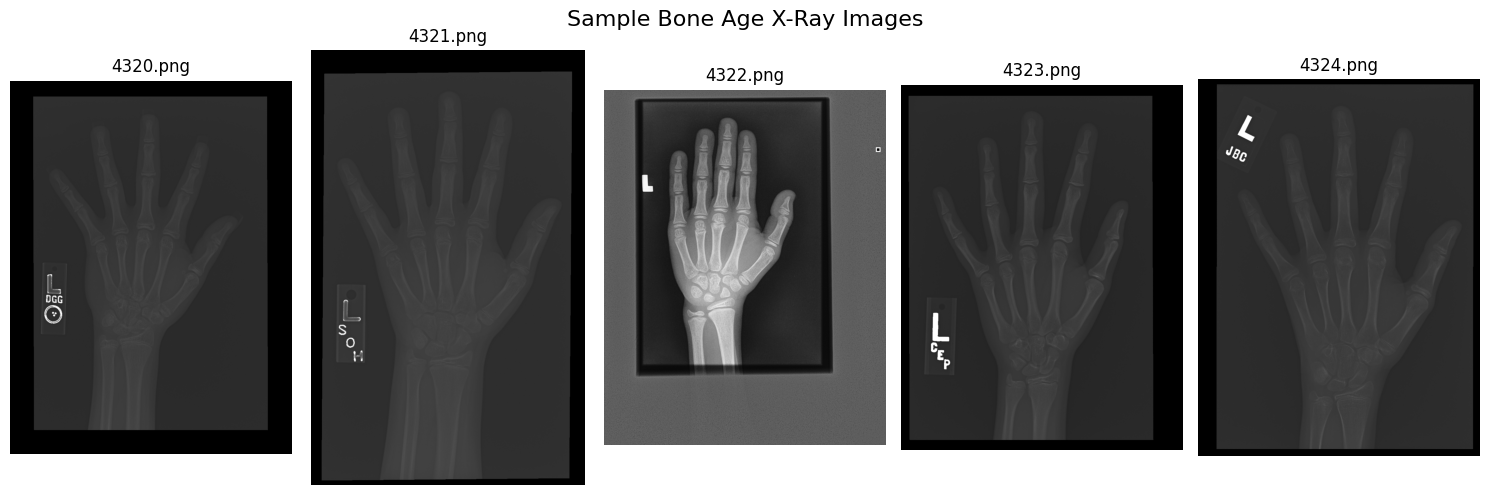

In [26]:
import os
import matplotlib.pyplot as plt
import cv2

# Define image directory
image_dir = "/content/boneage_dataset/boneage-training-dataset"

# List image files (you can adjust the number if needed)
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])[:5]

# Plot the sample images
plt.figure(figsize=(15, 5))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')

plt.suptitle("Sample Bone Age X-Ray Images", fontsize=16)
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd
import os

# Load the training metadata
train_csv = '/content/boneage-training-dataset.csv'
train_df = pd.read_csv(train_csv)

# Add full image paths
train_df['image_path'] = train_df['id'].astype(str) + '.png'
train_df['image_path'] = train_df['image_path'].apply(
    lambda x: os.path.join('/content/boneage_dataset/boneage-training-dataset', x)
)
x
# Filter out missing images
train_df = train_df[train_df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# Normalize bone age (optional)
train_df['boneage'] = train_df['boneage'].astype('float')
train_df['boneage'] = train_df['boneage'] / 240.0  # Normalize to range 0–1


In [29]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='boneage',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='raw',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='boneage',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='raw',
    shuffle=False
)


Found 32 validated image filenames.
Found 9 validated image filenames.


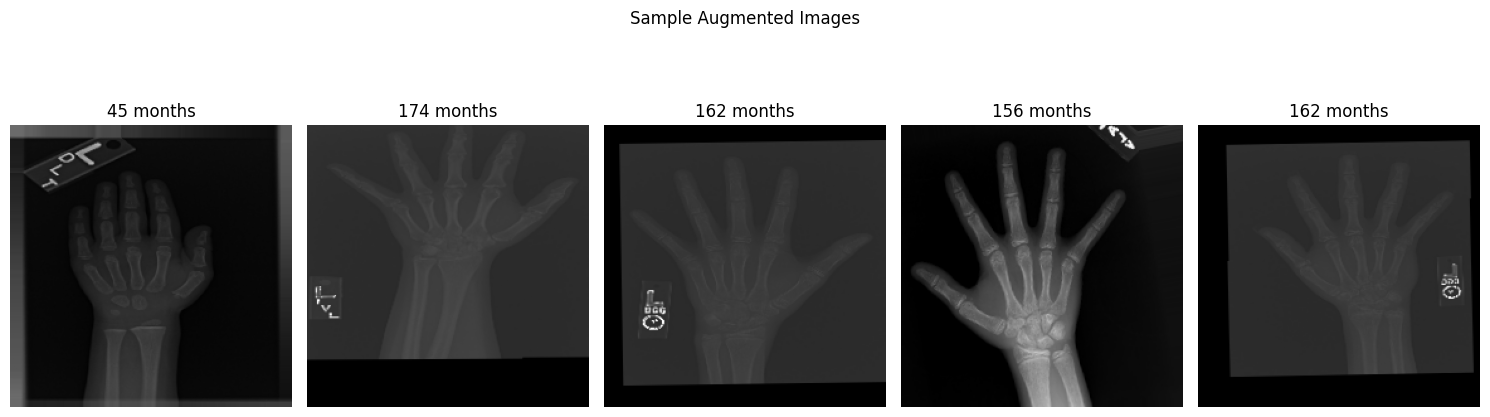

In [31]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"{labels[i]*240:.0f} months")
    plt.axis('off')
plt.suptitle("Sample Augmented Images")
plt.tight_layout()
plt.show()


In [32]:
from tensorflow.keras import layers, models, optimizers

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output: regression for bone age
])

model.compile(optimizer=optimizers.Adam(),
              loss='mean_squared_error',
              metrics=['mae'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,631,169 (21.48 MB)

 Trainable params: 5,631,169 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3452 - mae: 0.5559 - val_loss: 38.4595 - val_mae: 6.0304
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 36.7153 - mae: 5.5398 - val_loss: 0.2095 - val_mae: 0.4373
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.2436 - mae: 0.3681 - val_loss: 0.3996 - val_mae: 0.6224
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.4021 - mae: 0.6035 - val_loss: 0.3931 - val_mae: 0.6173
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.3964 - mae: 0.5990 - val_loss: 0.3831 - val_mae: 0.6092
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3869 - mae: 0.5915 - val_loss: 0.3738 - val_mae: 0.6015
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.3784 - mae: 0.5844 - val_loss: 0.3676 - val_mae: 0.5964
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3734 - mae: 0.5802 - val_loss: 0.3635 - val_mae: 0.5929
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.3695 - mae: 0.5769 - val_loss: 0.

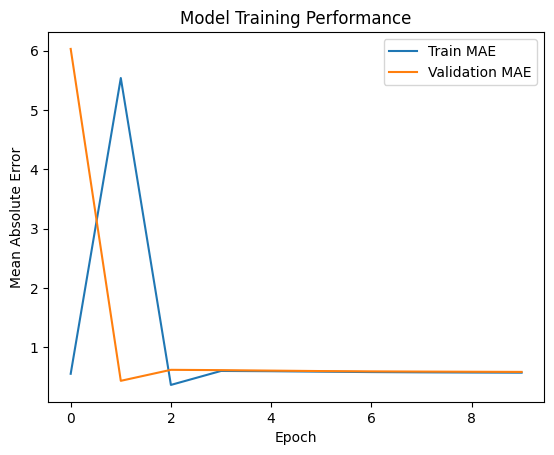

In [34]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Model Training Performance')
plt.legend()
plt.show()


In [11]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("BoneAgeETL").getOrCreate()
df = spark.read.csv("/content/boneage-training-dataset.csv", header=True, inferSchema=True)

df = df.withColumn("gender", df.male.cast("int")).drop("male")
df = df.withColumn("norm_age", df.boneage / 240)
df.show()


+----+-------+------+--------------------+
|  id|boneage|gender|            norm_age|
+----+-------+------+--------------------+
|1377|    180|     0|                0.75|
|1378|     12|     0|                0.05|
|1379|     94|     0| 0.39166666666666666|
|1380|    120|     1|                 0.5|
|1381|     82|     0|  0.3416666666666667|
|1382|    138|     1|               0.575|
|1383|    150|     1|               0.625|
|1384|    156|     1|                0.65|
|1385|     36|     1|                0.15|
|1387|    138|     1|               0.575|
|1388|    126|     0|               0.525|
|1389|    138|     1|               0.575|
|1390|    156|     1|                0.65|
|1391|    180|     1|                0.75|
|1393|    132|     0|                0.55|
|1394|     57|     1|              0.2375|
|1395|    120|     0|                 0.5|
|1396|    188|     0|  0.7833333333333333|
|1398|      4|     0|0.016666666666666666|
|1399|     36|     0|                0.15|
+----+-----

In [ ]:
SELECT AVG(boneage) AS avg_age, MIN(boneage), MAX(boneage) FROM boneage_data;

SELECT male, COUNT(*) FROM boneage_data GROUP BY male;
